# Effect of automation on complexity behavior

## Setup

In [1]:
import process_simulation
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# reload the process_simulation
# import importlib
# importlib.reload(process_simulation)

## Perform and plot single simulation

In [2]:
# simulation parameters in accordance with Pentland p.27 (lowest bounds for all parameters except r)
t = 5000 # number of iterations (5000 default)
l = 100 # lexicon: number of different process steps
m = 5 # number of subunits of the process, needs to be a factor of l
r = 50 # number of historic sequences remembered
n = 5

# set variability metrics
v_m = 0.005
v_a = 0
v_m_e = 0.01
v_a_e = 0.03

# set automation degree and exception percentage 
a = 0.5
e = 0.1

In [3]:
my_simulation = process_simulation.ProcessSimulationModel(t, l, m, r, n, v_m=v_m, v_a=v_a, v_m_e=v_m_e, v_a_e=v_a_e, a=a, e=e)

In [4]:
# run the simulation and store runtime dynamics
import cProfile
import pstats
from io import StringIO

# Create a profiler object
profiler = cProfile.Profile()

# Start profiling
profiler.enable()

# Run the simulation
adjacency_matrices = my_simulation.run_simulation(normalize_adjacency_matrices=True)

# Stop profiling
profiler.disable()

# Create a stream to hold the profile data
stream = StringIO()

# Create a Stats object and sort the profile data
stats = pstats.Stats(profiler, stream=stream).sort_stats(pstats.SortKey.CUMULATIVE)

# Print the profile to stream
stats.print_stats()

# Display the profile data in the Jupyter notebook
profile_data = stream.getvalue()
print(profile_data)

# Optionally, you can save the profile data to a file for later analysis
with open("profile_output.txt", "w") as f:
    f.write(stream.getvalue())

         8031488 function calls (8031476 primitive calls) in 5.400 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.358    0.358    5.369    5.369 c:\Users\Lennart\Documents\Workspace\upc_csn_08_final_project\process_simulation.py:134(run_simulation)
     5000    1.581    0.000    4.605    0.001 c:\Users\Lennart\Documents\Workspace\upc_csn_08_final_project\process_simulation.py:94(next_sequence)
   415802    0.279    0.000    1.197    0.000 c:\Users\Lennart\Tools\Miniconda\envs\process_simulation\Lib\site-packages\numpy\_core\fromnumeric.py:2338(sum)
   831092    0.317    0.000    1.157    0.000 c:\Users\Lennart\Tools\Miniconda\envs\process_simulation\Lib\site-packages\numpy\_core\fromnumeric.py:51(_wrapfunc)
   415802    0.369    0.000    0.868    0.000 c:\Users\Lennart\Tools\Miniconda\envs\process_simulation\Lib\site-packages\numpy\_core\fromnumeric.py:69(_wrapreduction)
   415546    0.165    0.000    0.82

In [5]:
# sampled_adjacency_matrices = process_simulation.sample_adjacency_matrices(adjacency_matrices, 101)
results_df = process_simulation.get_metrics_for_sim_results(adjacency_matrices, metrics=['number of connected nodes', 'number of edges', 'density', 'avg degree', 'est. count simple paths'], monte_carlo_iterations=n*l)
results_df

,number of connected nodes,number of edges,avg degree,density,est. count simple paths
time,,,,,
0,100,99,0.990000,0.010000,1.000000
1,100,100,1.000000,0.010101,1.202264
2,100,103,1.030000,0.010404,2.089296
3,100,104,1.040000,0.010505,2.511886
4,100,104,1.040000,0.010505,2.511886
...,...,...,...,...,...
4995,72,111,1.541667,0.021714,9.120108
4996,72,110,1.527778,0.021518,7.585776
4997,72,110,1.527778,0.021518,7.585776


## Comparisson of Complexity metrics

In [6]:
results_df_norm = pd.DataFrame()

# normalize all complexity metrics to plot them in one graph and observe their differences
def absolute_maximum_scale(series):
    return series / series.abs().max()
for col in results_df.columns:
    results_df_norm[col] = absolute_maximum_scale(results_df[col])

# only show a few timestamps
# print(results_df_norm.iloc[::5].to_latex())
display(results_df_norm.head)

<bound method NDFrame.head of       number of connected nodes  number of edges  avg degree   density  \
time                                                                     
0                          1.00         0.568966    0.483621  0.400000   
1                          1.00         0.574713    0.488506  0.404040   
2                          1.00         0.591954    0.503161  0.416162   
3                          1.00         0.597701    0.508046  0.420202   
4                          1.00         0.597701    0.508046  0.420202   
...                         ...              ...         ...       ...   
4995                       0.72         0.637931    0.753113  0.868545   
4996                       0.72         0.632184    0.746328  0.860720   
4997                       0.72         0.632184    0.746328  0.860720   
4998                       0.75         0.666667    0.755556  0.836036   
4999                       0.75         0.666667    0.755556  0.836036   

      e

In [7]:
results_df_norm.corr()

,number of connected nodes,number of edges,avg degree,density,est. count simple paths
number of connected nodes,1.000000,0.769827,0.140401,-0.743048,0.270500
number of edges,0.769827,1.000000,0.737517,-0.152802,0.496190
avg degree,0.140401,0.737517,1.000000,0.551812,0.468312
density,-0.743048,-0.152802,0.551812,1.000000,0.099364
est. count simple paths,0.270500,0.496190,0.468312,0.099364,1.000000


<Figure size 640x480 with 0 Axes>

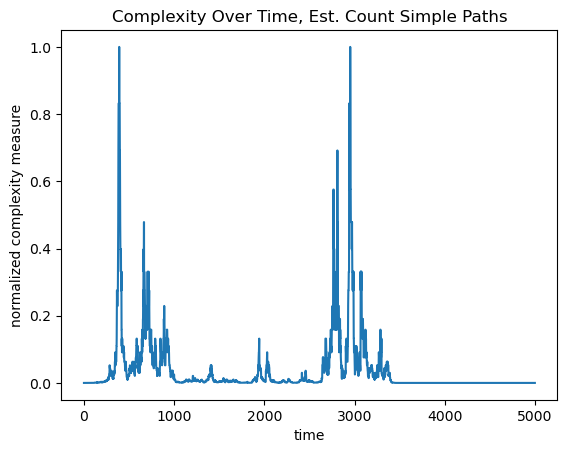

In [8]:
f = plt.figure()
ax = results_df_norm[['est. count simple paths']].plot(title="Complexity Over Time, Est. Count Simple Paths")
ax.set_ylabel("normalized complexity measure")
ax.get_legend().remove()
plt.savefig('experiment_results/plot_complexity_simple paths.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

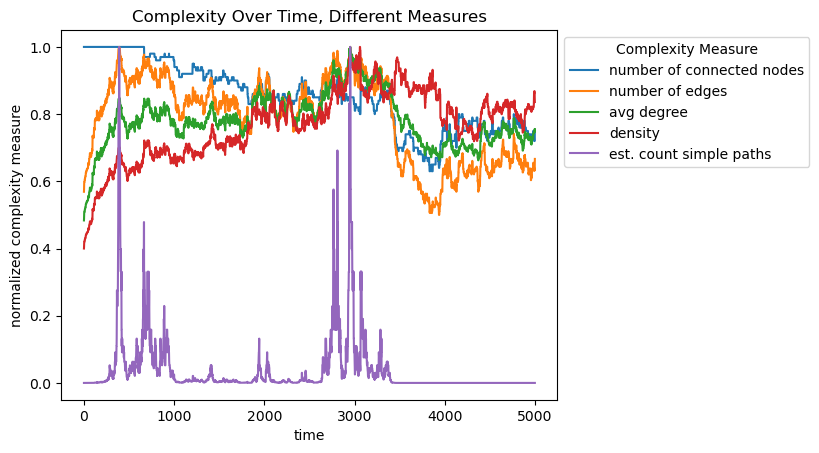

In [9]:
f = plt.figure()
ax = results_df_norm.plot(title="Complexity Over Time, Different Measures")
ax.set_ylabel("normalized complexity measure")
legend = plt.legend(title='Complexity Measure', bbox_to_anchor=(1.0, 1.0))
legend_frame = legend.get_frame()
legend_frame.set_facecolor('white')

plt.savefig('experiment_results/plot_complexity_measures.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

<Axes: xlabel='time'>

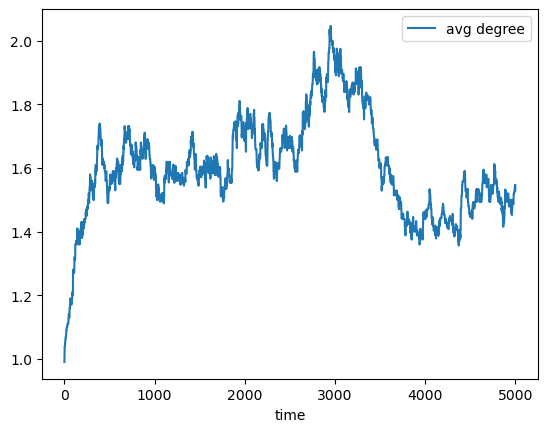

In [10]:
results_df.plot(y='avg degree')

<Axes: xlabel='time'>

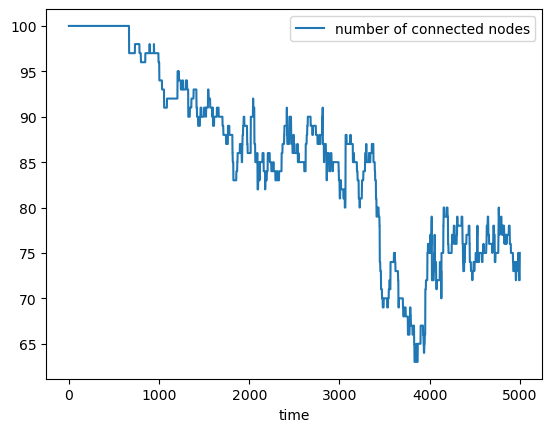

In [11]:
results_df.plot(y='number of connected nodes')

## Plot some graphs at different times    

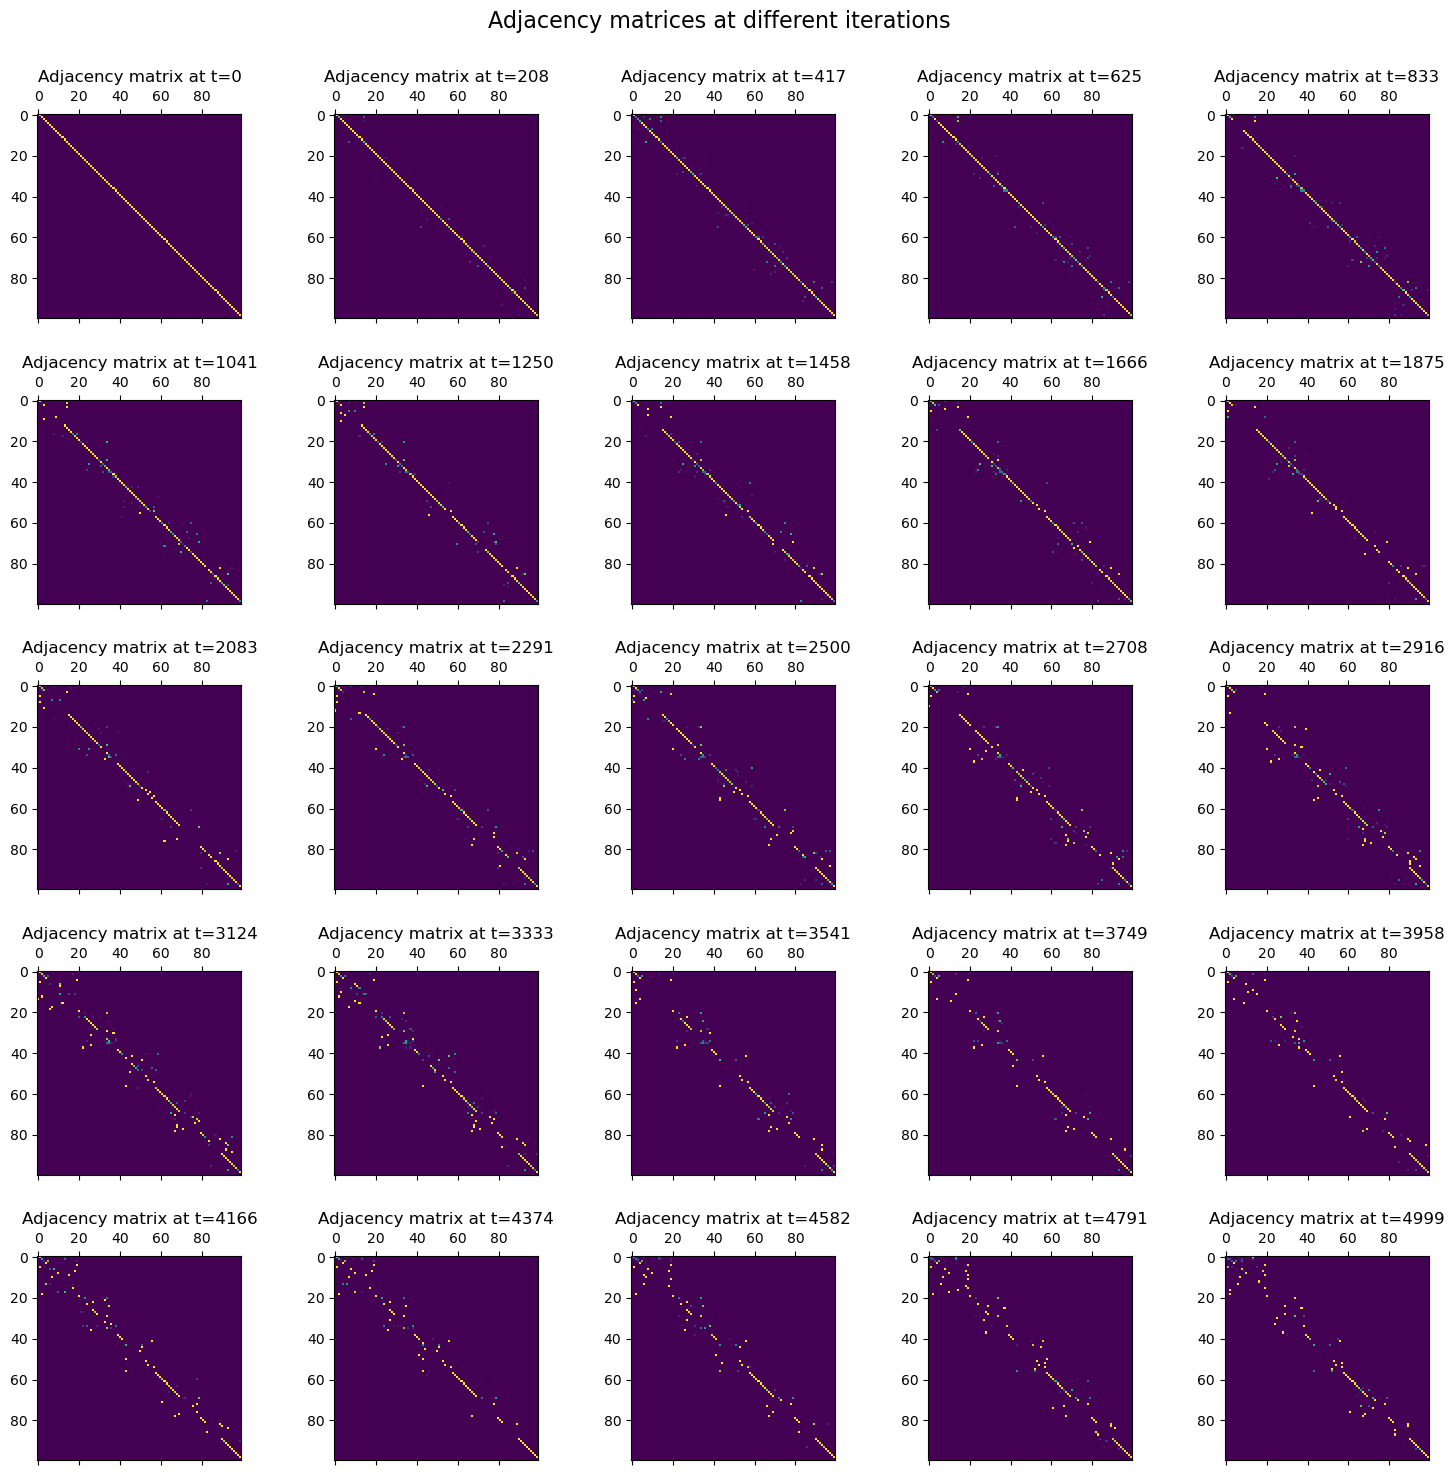

In [12]:
number_of_plots = 5*5

sampled_adjacency_matrices = process_simulation.sample_adjacency_matrices(adjacency_matrices, number_of_plots)

# Number of columns is fixed at 5
num_cols = 5
num_matrices = len(sampled_adjacency_matrices)
num_rows = (num_matrices + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot each adjacency matrix in its respective subplot
for idx, (i, adjacency_matrix) in enumerate(sampled_adjacency_matrices.items()):
    axes[idx].matshow(adjacency_matrix)
    axes[idx].set_title(f"Adjacency matrix at t={i}")

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95]) # add some space at the top
plt.subplots_adjust(hspace=0.4) 

# Show the plot
fig.suptitle('Adjacency matrices at different iterations', fontsize=16)
plt.show()

In [13]:
# get metrics for simulation that can be compared to Pentland
aggregate_sim_result = process_simulation.get_aggregate_sim_result(adjacency_matrices, l)
aggregate_sim_result

{'max_complexity': 3630780.5477010175,
 'mean_complexity': np.float64(103610.74582977308),
 'has_phase_change': True,
 'time_to_complexity': np.int64(346)}

## Try different parameters for a and e

In [ ]:
# simulation parameters in accordance with Pentland p.27 (lowest bounds for all parameters except r)
t = 5000 # number of iterations (5000 default)
l = 100 # lexicon: number of different process steps
m = 5 # number of subunits of the process, needs to be a factor of l
r = 50 # number of historic sequences remembered
n = 5

# set variability metrics
v_m = 0.005
v_a = 0
v_m_e = 0.01
v_a_e = 0.03

# set automation degree and exception percentage 
a_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] # [0, 0.2, 0.4, 0.6, 0.8, 1]
e_values = [0,0.05,0.1,0.15,0.2,0.25,0.3] # [0, 0.001, 0.01, 0.1, 0.2]

simulation_runs = 1

all_simulation_data = 'experiment_results/all_simulation_data.h5'

summary_results_csv_path = 'experiment_results/summary_results.csv'

In [ ]:
import csv

all_simulation_results_list = []

def run_simulation_and_get_results(my_simulation):
    adjacency_matrices = my_simulation.run_simulation()
    simulation_result = process_simulation.get_aggregate_sim_result(adjacency_matrices, l)
    process_simulation.save_simulation_hdf5(all_simulation_data, my_simulation, adjacency_matrices, simulation_result)
    return simulation_result

# Open the CSV file in append mode
with open(summary_results_csv_path, 'a', newline='') as csvfile:
    # Define the CSV writer
    fieldnames = ['version', 't', 'l', 'm', 'r', 'n', 'v_m', 'v_a', 'v_m_e', 'v_a_e', 'e', 'a', 'simulation_runs', 'max_complexity', 'mean_complexity', 'has_phase_change', 'time_to_complexity']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header row if the file is empty
    csvfile.seek(0, 2)  # Move the cursor to the end of the file
    if csvfile.tell() == 0:
        writer.writeheader()
    
    # Loop through e_values and a_values
    for e in e_values:
        for a in a_values:
            my_simulation = process_simulation.ProcessSimulationModel(t, l, m, r, n, v_m=v_m, v_a=v_a, v_m_e=v_m_e, v_a_e=v_a_e, a=a, e=e)
            simulation_results = Parallel(n_jobs=20)(delayed(run_simulation_and_get_results)(my_simulation) for _ in range(simulation_runs))
            all_simulation_results_list.append(simulation_results)

            # Write each result to the CSV file
            for result in simulation_results:
                # add the configuration fields
                result['version'] = process_simulation.VERSION
                result['t'] = t
                result['l'] = l
                result['m'] = m
                result['r'] = r
                result['n'] = n
                result['v_m'] = v_m
                result['v_a'] = v_a
                result['v_m_e'] = v_m_e
                result['v_a_e'] = v_a_e
                result['e'] = e
                result['a'] = a
                result['simulation_runs'] = simulation_runs # technically, the number of simulation runs can also derived from counting rows with same settings

                writer.writerow(result)

## Analyze results

### Read simulation results from csv

In [ ]:
one_result_per_line_df = pd.read_csv('simulation_results.csv')

# delete results from old version
one_result_per_line_df = one_result_per_line_df[one_result_per_line_df.version == process_simulation.VERSION]

# aggregate results with same parameters
grouped_df = one_result_per_line_df.groupby(['version', 't', 'l', 'm', 'r', 'n', 'v_m', 'v_a', 'v_m_e', 'v_a_e', 'e', 'a'])

aggregated_df = grouped_df.agg({
    'simulation_runs': 'count',
    'max_complexity': ['mean', 'max', 'std'],
    'mean_complexity': ['mean', 'max', 'std'],
    'has_phase_change': ['mean', 'max', 'std'],
    'time_to_complexity': ['mean', 'max', 'std']
})


display(aggregated_df)

simulation_runs  \
                                                                  count   
version t    l   m r  n v_m   v_a v_m_e v_a_e e     a                     
0.01    5000 100 5 50 5 0.005 0   0.01  0.03  0.000 0.0             500   
                                                    0.1             500   
                                                    0.2             500   
                                                    0.3             500   
                                                    0.4             500   
                                                    0.5             500   
                                                    0.6             500   
                                                    0.7             500   
                                                    0.8             500   
                                                    0.9             500   
                                                    1.0             500   
                                              0.001 0.0             500   
                                                    0.1             500   
                                                    0.2             500   
                                                    0.3             500   
                                                    0.4             500   
                                                    0.5             500   
                                                    0.6             500   
                                                    0.7             500   
                                                    0.8             500   
                                                    0.9             500   
                                                    1.0             500   
                                              0.010 0.0             500   
                                                    0.1             500   
                                                    0.2             500   
                                                    0.3             500   
                                                    0.4             500   
                                                    0.5             500   
                                                    0.6             500   
                                                    0.7             500   
                                                    0.8             500   
                                                    0.9             500   
                                                    1.0             500   
                                              0.100 0.0             500   
                                                    0.1             500   
                                                    0.2             500   
                                                    0.3             500   
                                                    0.4             500   
                                                    0.5             500   
                                                    0.6             500   
                                                    0.7             500   
                                                    0.8             500   
                                                    0.9             500   
                                                    1.0             500   
                                              0.200 0.0             500   
                                                    0.1             500   
                                                    0.2             500   
                                                    0.3             500   
                                                    0.4             500   
                                                    0.5             500   
                                                    0.6             500   
      

version     t    l  m   r  n    v_m v_a v_m_e v_a_e  ... max_complexity  \
                                                        ...            std   
44    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   4.078674e+21   
45    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   1.780857e+20   
46    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   8.526599e+17   
47    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   5.182432e+18   
48    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   4.712180e+18   
49    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   3.096690e+22   
50    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   9.343609e+22   
51    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   2.214656e+18   
52    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   2.144434e+20   
53    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   1.714186e+19   
54    0.01  5000  100  5  50  5  0.005   0  0.01  0.03  ...   2.140640e+20   

   mean_complexity                             has_phase_change        \
              mean           max           std             mean   max   
44    9.018839e+17  4.416737e+20  1.975349e+19            0.804  True   
45    3.651110e+16  1.791269e+19  8.011711e+17            0.798  True   
46    1.078245e+14  4.214566e+16  1.894704e+15            0.788  True   
47    1.800970e+15  3.895804e+17  2.122503e+16            0.780  True   
48    2.038878e+15  3.204309e+17  2.298077e+16            0.794  True   
49    7.017862e+18  3.273139e+21  1.466765e+20            0.796  True   
50    2.097435e+19  1.048461e+22  4.688857e+20            0.758  True   
51    6.719030e+14  1.792829e+17  9.540570e+15            0.754  True   
52    4.367218e+16  2.030225e+19  9.085237e+17            0.780  True   
53    3.005746e+15  7.906524e+17  4.138343e+16            0.744  True   
54    2.502119e+16  1.204325e+19  5.387075e+17            0.732  True   

             time_to_complexity                       
         std               mean     max          std  
44  0.397366           1068.174  4798.0   932.269472  
45  0.401894           1110.098  4859.0  1015.256679  
46  0.409134           1080.274  4890.0   977.044886  
47  0.414661           1058.162  4781.0   934.004840  
48  0.404836           1055.198  4889.0   948.103192  
49  0.403373           1040.432  4865.0   941.265162  
50  0.428723           1083.566  4962.0   920.058113  
51  0.431110           1108.724  4833.0   988.023421  
52  0.414661           1045.108  4877.0   973.351008  
53  0.436859           1119.554  4782.0   992.153167  
54  0.443361           1021.464  4964.0   982.181465  

[11 rows x 25 columns]

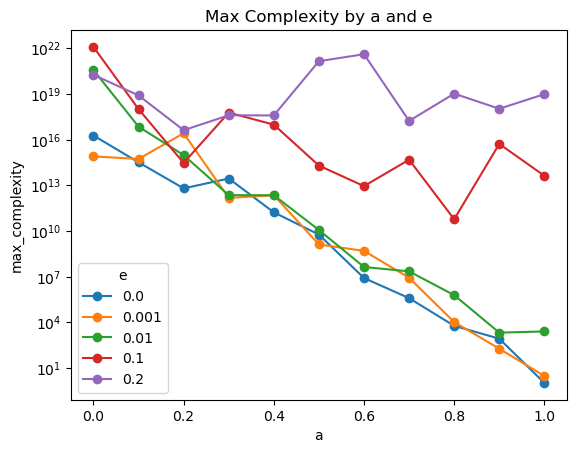

In [ ]:
flat_aggregated_df = aggregated_df.reset_index()

# plot max complexity

# Create a pivot table to reshape the data for plotting
pivot_df = flat_aggregated_df.pivot(index='a', columns='e', values=('max_complexity', 'mean'))

# Plot the data
ax = pivot_df.plot(kind='line', marker='o')

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('a')
plt.ylabel('max_complexity')
plt.title('Max Complexity by a and e')
plt.legend(title='e')

# Show the plot
plt.show()

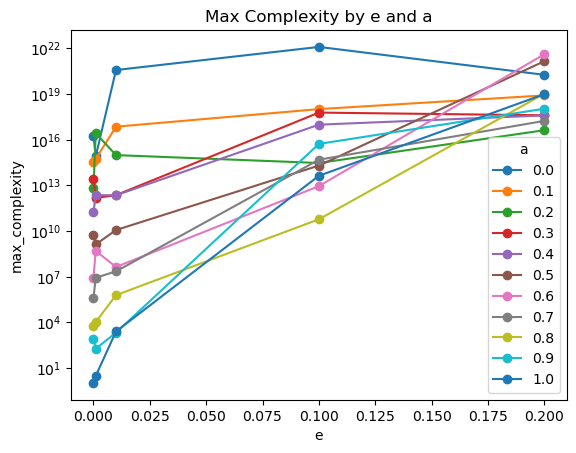

In [ ]:
flat_aggregated_df = aggregated_df.reset_index()

# plot max complexity

# Create a pivot table to reshape the data for plotting
pivot_df = flat_aggregated_df.pivot(index='e', columns='a', values=('max_complexity', 'mean'))

# Plot the data
ax = pivot_df.plot(kind='line', marker='o')

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('e')
plt.ylabel('max_complexity')
plt.title('Max Complexity by e and a')
plt.legend(title='a')

# Show the plot
plt.show()

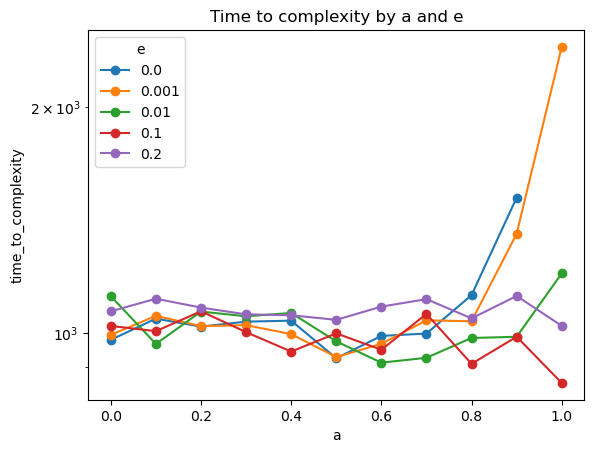

In [ ]:

# plot time to complexity

# Create a pivot table to reshape the data for plotting
pivoted_flat_df = flat_aggregated_df.pivot(index='a', columns='e', values=('time_to_complexity', 'mean'))

# Plot the data
ax = pivoted_flat_df.plot(kind='line', marker='o')

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('a')
plt.ylabel('time_to_complexity')
plt.title('Time to complexity by a and e')
plt.legend(title='e')

# Show the plot
plt.show()